In [1]:
# import the necessary packages
!pip3 install imutils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2

## Load dataset

In [2]:
import tensorflow as tf
_URL = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

824887076/824887076 [==============================] - 5s 0us/step


In [3]:
zip_dir

'/root/.keras/datasets/cats_and_dogs.zip'

In [4]:
%%capture
!unzip /root/.keras/datasets/cats_and_dogs.zip;

In [5]:
!ls

 CDLA-Permissive-2.0.pdf   PetImages  'readme[1].txt'   sample_data


In [6]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
IMG_SIZE = 224
INIT_LR = 1e-4
BS = 256
EPOCHS = 1

In [7]:
train = ImageDataGenerator(
  rescale = 1./255,
  horizontal_flip=True,
  vertical_flip=True,
  shear_range=0.2,
  zoom_range=0.2,
  rotation_range=40, # Degree range for random rotations
  width_shift_range=0.2,
  height_shift_range=0.2,
  fill_mode='nearest',
  validation_split=0.2)

In [8]:
dest = 'PetImages'

## Removing Corrupt images

In [9]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

In [10]:
path = Path('PetImages/Cat').rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

PetImages/Cat/666.jpg


In [11]:
import os
try:
    os.remove("PetImages/Cat/666.jpg")
    print("removed")
except:
  print("can't remove")
  pass

removed


In [12]:
path = Path('PetImages/Dog').rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

PetImages/Dog/11702.jpg


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [13]:
import os
try:
    os.remove("PetImages/Dog/11702.jpg")
    print("removed")
except:
  print("can't remove")
  pass

removed


## Train and Valid Set

In [14]:
trainset = train.flow_from_directory(dest,
  target_size = (IMG_SIZE,IMG_SIZE),
  batch_size = BS,
  shuffle=False,
  seed=42,
  color_mode='rgb',
  subset = "training",
  class_mode='categorical')


Found 20000 images belonging to 2 classes.


In [15]:
validset = train.flow_from_directory(dest,
  target_size = (IMG_SIZE,IMG_SIZE),
  batch_size = BS,
  shuffle=False,
  seed=42,
  color_mode='rgb',
  subset = "validation",
  class_mode='categorical')

Found 4998 images belonging to 2 classes.


In [16]:
NUM_CLASSES = 2

## Model Architecture - Xception!

In [17]:
from keras.applications import EfficientNetV2B0

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = EfficientNetV2B0(weights="imagenet", include_top=False,
                     input_tensor=Input(shape=(IMG_SIZE,IMG_SIZE, 3)))


# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.8)(headModel)
headModel = Dense(NUM_CLASSES, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# for fine tuning
# for layer in baseModel.layers[-10:]:
#   layer.trainable = True

# compile our model
print("[INFO] compiling model...")
opt = Adam()
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")

24274472/24274472 [==============================] - 2s 0us/step
[INFO] compiling model...
[INFO] training head...


## Training

In [18]:
H = model.fit(
	trainset,
  validation_data = validset,
	epochs=EPOCHS)

79/79 [==============================] - 305s 4s/step - loss: 0.7098 - accuracy: 0.4241 - val_loss: 0.6931 - val_accuracy: 0.5000


In [19]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save('cat_dog', save_format="h5")

[INFO] saving mask detector model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Accuracy Loss Plot

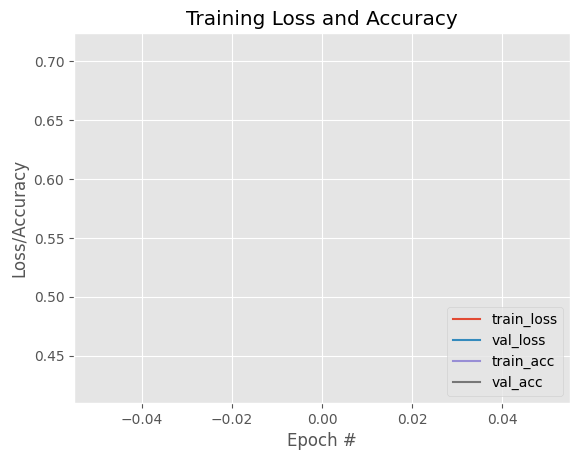

<Figure size 640x480 with 0 Axes>

In [20]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.show()
plt.savefig('graph.png')

# Fine Tuning

In [22]:
# Unfreeze some layers in the base model for fine-tuning
for layer in baseModel.layers[-10:]:
    layer.trainable = True

baseModel.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
F = model.fit(
	trainset,
  validation_data = validset,
	epochs=EPOCHS)

79/79 [==============================] - 359s 4s/step - loss: 0.9262 - accuracy: 0.5003 - val_loss: 0.7078 - val_accuracy: 0.5062
